# Prinicipal Component analysis

### What is it?

- Statistical technique that simplifies a data table consisting of cases and variables into its fundamental characteristics, known as principal components.


- These principal components are linear combinations of the original variables.


- A small number of principal components capture most of the variability in the data, (similar to 80-20 rule).


- The original data table can be approximated using only these few principal components.

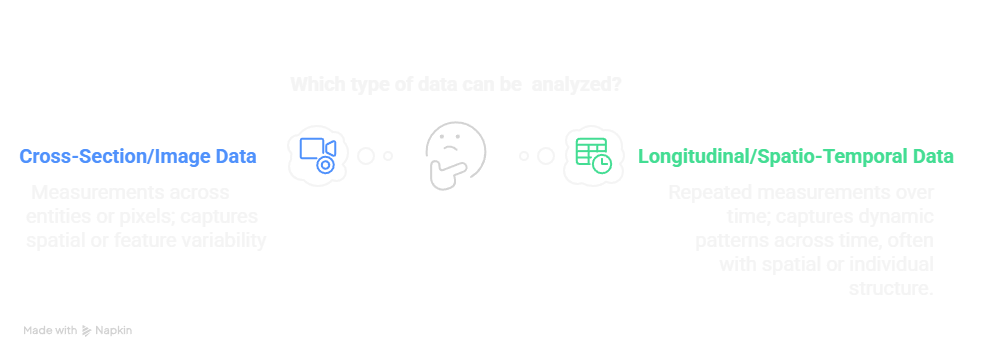

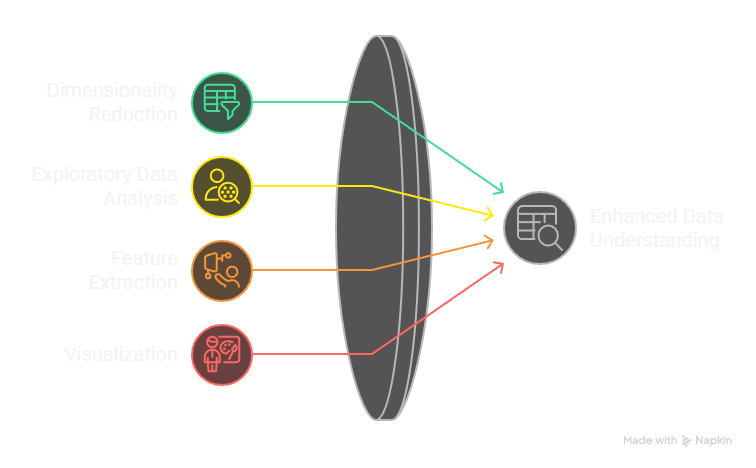

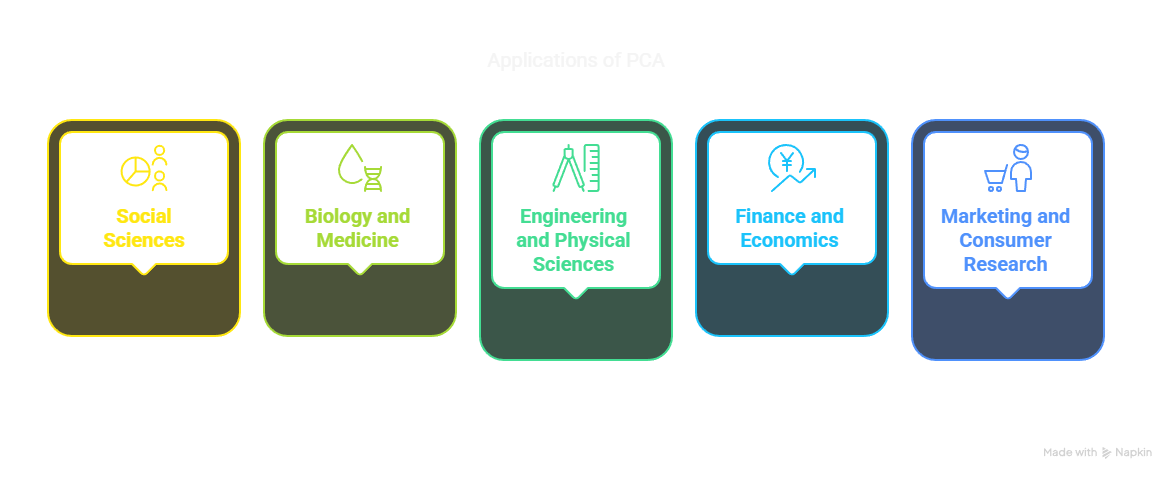

### Case study - 1

<video controls src="SpringMassOscillation3D.mp4" title="Title"></video>

#### Objective: We want to learn the dynamics of the block from the 2D video data from 3 cameras

- We assume that we do not know how the mass actually moves.

- Our collected data has 6 timeseries. $x_i(t)\,,y_i(t)$ from each camera ($i=1,2,3$)

Define the data matrix $W \in \mathbb{R}^{n \times 6}$, which contains the 2D time series from 3 cameras each providing $x$ and $y$ values. With $n$ time steps and 6 features: $x$ and $y$ from 3 cameras looks like this:


$$
X =
\begin{bmatrix}
x_1(t_1) & y_1(t_1) & x_2(t_1) & y_2(t_1) & x_3(t_1) & y_3(t_1) \\
x_1(t_2) & y_1(t_2) & x_2(t_2) & y_2(t_2) & x_3(t_2) & y_3(t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_1(t_n) & y_1(t_n) & x_2(t_n) & y_2(t_n) & x_3(t_n) & y_3(t_n)
\end{bmatrix}
$$


- Each **row** corresponds to one time step $t_k$.
- Each **column** corresponds to a specific signal: either $x_i(t)$ or $y_i(t)$ from camera $i$.

**PART 1**

#### Data-generation

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sci_mplstyle_package
from matplotlib.ticker import MaxNLocator

# Use STIX font and enable LaTeX-style math rendering
plt.rcParams.update({
    "figure.dpi": 100
})
# plt.rcParams.keys()

Duplicate key in file 'c:\\Users\\supar\\.conda\\envs\\pca_tutorial\\Lib\\site-packages\\sci_mplstyle_package\\style_files\\publication.mplstyle', line 64 ('axes.axisbelow : True')


In [2]:
def project_point(camera_pos, look_at, point, up_hint=np.array([0,1,0])):
    """
    Project a 3D point into a 2D image plane for a camera.
    Constructs a camera coordinate system using:
      - view_dir: normalized vector from camera_pos to look_at.
      - right: computed from the cross product of up_hint and view_dir.
      - up: recomputed to ensure orthogonality.
    Returns the (x, y) coordinates on the image plane.
    """
    # Compute view direction (camera's z-axis)
    view_dir = look_at - camera_pos
    view_dir = view_dir / np.linalg.norm(view_dir)
    
    # Adjust up_hint if too parallel to view_dir
    if np.abs(np.dot(view_dir, up_hint)) > 0.99:
        up_hint = np.array([0, 0, 1])
    
    # Compute the right (x-axis) and then the up (y-axis)
    right = np.cross(up_hint, view_dir)
    right = right / np.linalg.norm(right)
    up = np.cross(view_dir, right)
    up = up / np.linalg.norm(up)
    
    # Compute projection by dotting the relative vector with right and up
    rel = point - camera_pos
    x_proj = np.dot(rel, right)
    y_proj = np.dot(rel, up)
    return np.array([x_proj, y_proj]), np.array([right,up])

# Define three camera positions.
# Each camera is positioned to provide distinct x and y projections.
cameras = {
    "Camera_1": np.array([0, 0, -2]),
    "Camera_2": np.array([5, 2.5, 0.5]),
    "Camera_3": np.array([1.5, -1.5, 0.5])
}
        
        
look_at = np.array([0, 0, 0])

# Time values for the simulation.
t_values = np.linspace(0, 3, 100)

def mass_top(t):
    """
    Returns the 3D position of the top of the mass at time t.
    The mass oscillates vertically:
        z(t) = 0.5 * cos(2*pi*0.5*t)
    """
    z = 0.5 * np.cos(2 * np.pi * 0.5 * t)
    return np.array([0, 0, z])

# Generate the 2D projections for each camera.
# Each camera provides two time series: one for x and one for y.
data = {}
for cam_name, cam_pos in cameras.items():
    x_series = []
    y_series = []
    for t in t_values:
        pt3d = mass_top(t)
        pt2d, axs = project_point(cam_pos, look_at, pt3d)
        x_series.append(pt2d[0])
        y_series.append(pt2d[1])
    data[cam_name] = {"x": np.array(x_series), "y": np.array(y_series), "x_axis": axs[0], "y_axis": axs[1]}

# Stack the six time series into a data matrix.
# Each row corresponds to a time step and the columns are:
# [Cam1_x, Cam1_y, Cam2_x, Cam2_y, Cam3_x, Cam3_y]
X = np.column_stack([data["Camera_1"]["x"],
                     data["Camera_1"]["y"],
                     data["Camera_2"]["x"],
                     data["Camera_2"]["y"],
                     data["Camera_3"]["x"],
                     data["Camera_3"]["y"]])

X_ax = np.vstack([data["Camera_1"]["x_axis"].T,
                     data["Camera_1"]["y_axis"].T,
                     data["Camera_2"]["x_axis"].T,
                     data["Camera_2"]["y_axis"].T,
                     data["Camera_3"]["x_axis"].T,
                     data["Camera_3"]["y_axis"].T])

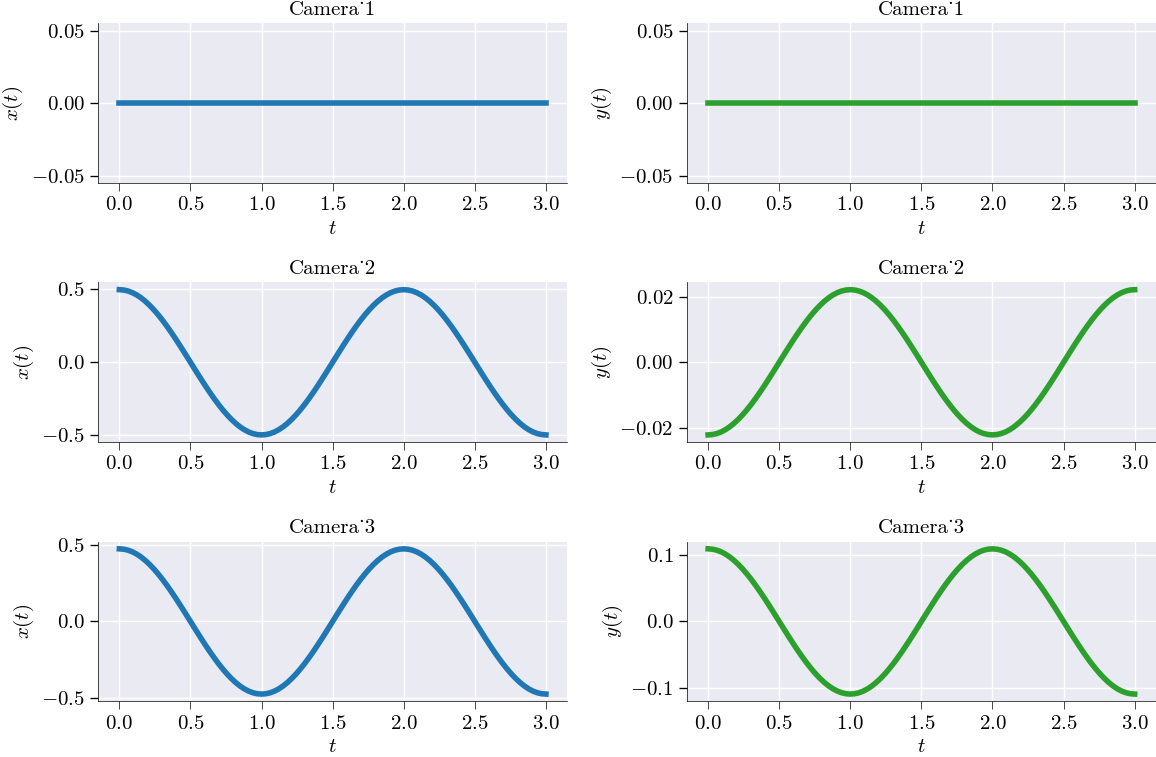

In [3]:
# Plot x and y time series for each camera
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
camera_names = ["Camera_1", "Camera_2", "Camera_3"]

for i, cam in enumerate(camera_names):
    axs[i, 0].plot(t_values, data[cam]["x"], color='tab:blue',lw=4)
    axs[i, 0].set_title(f"{cam}")
    axs[i, 0].set_xlabel("$t$")
    axs[i, 0].set_ylabel("$x(t)$")

    axs[i, 1].plot(t_values, data[cam]["y"], color='tab:green',lw=4)
    axs[i, 1].set_title(f"{cam}")
    axs[i, 1].set_xlabel("$t$")
    axs[i, 1].set_ylabel("$y(t)$")

plt.tight_layout()
plt.show()


### Variance and covariance

---

**Variance:** The variance of a vector $\mathbf{a}$ with elements $ a_i $ (for $ i = 1, 2, \dots, n $) measures the spread of its elements around their mean. It is defined as:

$$
\text{Var}(\mathbf{a}) = \frac{1}{n-1} \sum_{i=1}^{n} (a_i - \bar{a})^2
$$

where $ \bar{a} = \frac{1}{n} \sum_{i=1}^{n} a_i $ is the mean of the vector. A higher variance indicates that the values are more dispersed from the mean, while a lower variance suggests they are more concentrated around it.

If $\overline{a} = 0$, variance can be expressed as a dot product

$$
\text{Var}(a) = \frac{1}{n-1} \mathbf{a} \cdot \mathbf{a}
$$

.

 **Covariance:** The covariance between two vectors **a** and **b**, each with $ n $ elements $ a_i $ and $ b_i $, measures how much the two variables change together. It is defined as:

$$
\text{Cov}(a, b) = \frac{1}{n-1} \sum_{i=1}^{n} (a_i - \bar{a})(b_i - \bar{b})
$$

where $ \bar{a} $ and $ \bar{b} $ are the means of vectors **a** and **b**, respectively.

- A **positive** covariance means that as $ a_i $ increases, $ b_i $ tends to increase as well.
- A **negative** covariance indicates that as $ a_i $ increases, $ b_i $ tends to decrease.
- A **zero** covariance suggests no linear relationship between the two.

Covariance is the fundamental building block of the **covariance matrix** used in PCA.

Assuming the vectors $\mathbf{a}$ and $\mathbf{b}$ have **zero mean**, the **covariance** can be written using the dot product as:

$$
\text{Cov}(\mathbf{a}, \mathbf{b}) = \frac{1}{n-1} \, \mathbf{a} \cdot \mathbf{b}
$$

where:
- $\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i$ is the dot product,
- $n$ is the number of elements.

---

### Covariance Matrix

The **covariance matrix** is a square matrix that summarizes the pairwise covariances between multiple zero-mean random variables (or features). For a data matrix $X \in \mathbb{R}^{n \times d}$, where each of the $n$ rows is a sample and each of the $d$ columns is a feature (assumed to have zero mean), the covariance matrix is defined as:

$$
\Sigma = \frac{1}{n} X^\top X
$$

Each entry of $\Sigma$ is given by:

$$
\Sigma_{ij} = \text{Cov}(x_i, x_j) = \frac{1}{n} \sum_{k=1}^{n} x_{ki} x_{kj}
$$


- The **diagonal entries** $\Sigma_{ii}$ represent the variances of individual features.
- The **off-diagonal entries** $\Sigma_{ij}$ represent the covariances between features $i$ and $j$.

$$
X =
\begin{bmatrix}
x_1(t_1) & y_1(t_1) & x_2(t_1) & y_2(t_1) & x_3(t_1) & y_3(t_1) \\
x_1(t_2) & y_1(t_2) & x_2(t_2) & y_2(t_2) & x_3(t_2) & y_3(t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
x_1(t_n) & y_1(t_n) & x_2(t_n) & y_2(t_n) & x_3(t_n) & y_3(t_n)
\end{bmatrix}
$$


$$
\Sigma = \frac{1}{n-1}
\begin{bmatrix}
\text{Var}(x_1) & \text{Cov}(x_1, y_1) & \cdots & \cdots & \cdots & \cdots \\
               & \text{Var}(y_1)       & \text{Cov}(y_1, x_2) & \cdots & \cdots & \cdots \\
               &                      & \text{Var}(x_2) & \text{Cov}(x_2, y_2) & \cdots & \cdots \\
               &                      &                 & \text{Var}(y_2) & \text{Cov}(y_2, x_3) & \cdots \\
               &                      &                 &                 & \text{Var}(x_3) & \text{Cov}(x_3, y_3) \\
               &                      &                 &                 &                 & \text{Var}(y_3)
\end{bmatrix}
$$

---
### Question: can I (linearly) transform X such that $\Sigma$ becomes diagonal?
---


<u>Step 1: Apply a linear transformation</u>


Let $X \in \mathbb{R}^{n \times d}$ be the mean-centered data matrix.  
We apply a linear transformation using a matrix $W \in \mathbb{R}^{d \times d}$:

$$
Z = XW
$$

The covariance matrix of the transformed data $Z$ is:

$$
\Sigma_Z = \frac{1}{n} Z^\top Z = \frac{1}{n} (XW)^\top (XW) = W^\top \left( \frac{1}{n} X^\top X \right) W = W^\top \Sigma W
$$

where $\Sigma = \frac{1}{n} X^\top X$ is the covariance matrix of $X$.


<u>Step 2: Goal — make $\Sigma_Z$ diagonal</u>

We want to choose $W$ such that:

$$
W^\top \Sigma W = D
$$

where $D$ is a diagonal matrix. That is, we seek a **linear transformation** that makes the features of $Z$ **uncorrelated**.


<u>Step 3: Solve the covariance eigenvalue problem</u>

This leads us to the **eigenvalue problem**:

$$
\Sigma \vec{v} = \lambda \vec{v}
$$

Let $V$ be the matrix whose columns are the eigenvectors $\vec{v}_1, \dots, \vec{v}_d$, and let $\Lambda = \text{diag}(\lambda_1, \dots, \lambda_d)$ be the corresponding diagonal matrix of eigenvalues. Then:

$$
\Sigma = V \Lambda V^\top
$$

Setting $W = V$ gives:

$$
\Sigma_Z = V^\top \Sigma V = \Lambda
$$



Choosing $W$ as the eigenvector matrix of $\Sigma$ diagonalizes the covariance matrix of $XW$. This is the foundation of **PCA**, where the eigenvectors define the principal directions and the eigenvalues represent the variance along those directions.

In [ ]:

def pca_from_covariance(X):
    
    n = X.shape[0]  # number of samples

    # Step 0: Preprocess the data
    
    X_standardized = X - np.mean(X, axis=0)

    
    # Step 1: Compute the covariance matrix
    Sigma = (1 / (n-1)) * X_standardized.T @ X_standardized  # shape (d, d)


    # Step 2: Solve the eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)


    # Step 3: Sort eigenvectors by decreasing eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    
    # Step 4: Compute the explained variance ratio
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance


    # Step 5: Project data onto principal components
    Z = X_standardized @ eigenvectors  # mean-centered data


    return Z, explained_variance_ratio, eigenvectors


In [19]:
Z, explained_variance_ratio, eigenvectors = pca_from_covariance(X)

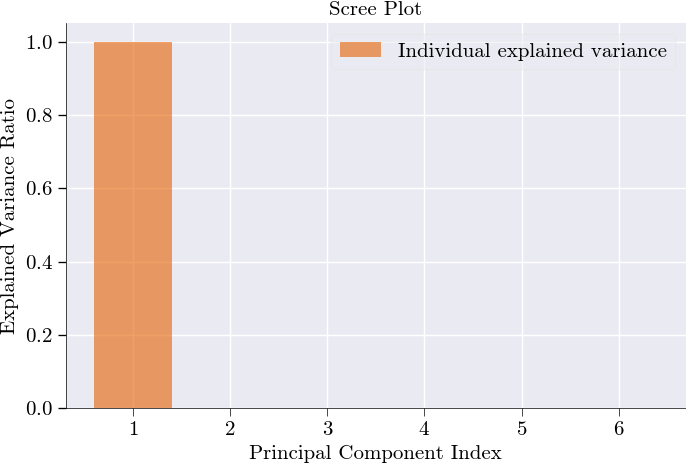

In [20]:
# Plot variance explained by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance_ratio)+1),
        explained_variance_ratio,
        alpha=0.6,
        align='center',
        label='Individual explained variance')

plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()


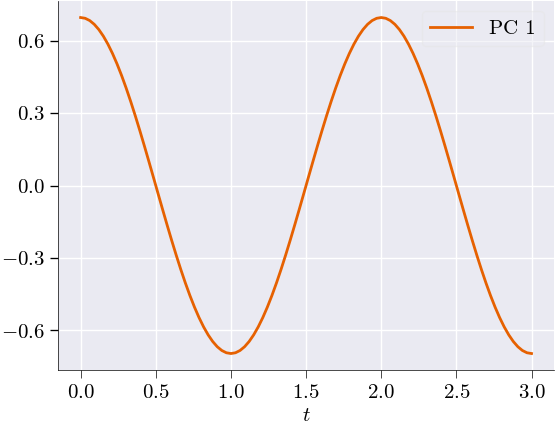

In [22]:
plt.plot(t_values, Z[:,0],label="PC 1",lw=2)
plt.xlabel("$t$")
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))  # Set max number of x-ticks
plt.legend()

### Using scikit-learn package

In [23]:
from sklearn.decomposition import PCA

Explained Variance Ratio for each component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000


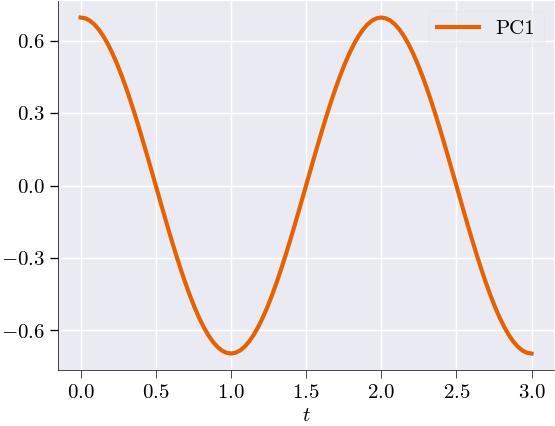

In [24]:
# Perform PCA on the dataset.
pca = PCA()

pca.fit(X)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio for each component:")

for i, ratio in enumerate(explained_variance):
    print(f"PC{i+1}: {ratio:.4f}")

# Transform the data to the principal component space.
X_pca = pca.transform(X)

# Plot the first principal component time series.
plt.plot(t_values, X_pca[:, 0], label="PC1",lw=3)
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=6))
plt.xlabel("$t$")
plt.legend()
plt.show()


In [ ]:
Z2 = X @ eigenvectors @ X_ax

#### Cross-section Data

In [ ]:
# Principal Component Analysis (PCA) Tutorial using scikit-learn

# ======================================================
# Step 0: Import Required Libraries
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns

# Set Seaborn plotting style
# Apply seaborn style (no grid) and LaTeX rendering
sns.set(style="white", context="notebook", palette="deep")
# Use STIX font and enable LaTeX-style math rendering
plt.rcParams.update({
    "text.usetex": False,             # Use mathtext, not full LaTeX engine
    "mathtext.fontset": "stix",       # Use STIX for math
    "font.family": "STIXGeneral",     # Use STIX for all text
    "axes.grid": False                # Disable grid
})


In [ ]:
# import sci_mplstyle_package

# Enable inline plots (only required in Jupyter notebooks)
# %matplotlib inline

# ======================================================
# Step 1: Load and Prepare the Dataset
# ======================================================

# Load the Iris dataset from scikit-learn
data = load_iris()

# Create a DataFrame from the feature data
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target variable (species) to the DataFrame
df['target'] = data.target

# Display dataset dimensions and sample rows
print("Shape of dataset:", df.shape)
print("\nSample data:")
print(df.head())

# ======================================================
# Step 2: Exploratory Data Analysis (EDA)
# ======================================================

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics for each feature
print("\nDescriptive statistics:")
print(df.describe())

# Pairplot to visualize distributions and relationships between features
sns.pairplot(df, hue='target', corner=True, diag_kind='kde',
             plot_kws={'alpha': 0.6}, markers=["o", "s", "D"])
plt.suptitle("Pairplot of Features Colored by Target Class", y=1.02)
plt.show()

# Correlation matrix
corr_matrix = df.drop('target', axis=1).corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Feature Correlation Heatmap")
plt.show()

# ======================================================
# Step 3: Standardize the Features
# ======================================================

# Extract features (exclude the target column)
features = data.feature_names
x = df.loc[:, features].values

# Standardize the feature data to mean=0, variance=1
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# ======================================================
# Step 4: Apply PCA
# ======================================================

# Create PCA object to reduce to 2 principal components
pca = PCA(n_components=2)

# Fit PCA on scaled data and transform the data
principal_components = pca.fit_transform(x_scaled)

# Create a new DataFrame with the two principal components
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['target'] = df['target']

# Explained variance ratio for each component
print("\nExplained variance ratio:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f}")

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("\nCumulative explained variance:")
print(cumulative_variance)

# ======================================================
# Step 5: Visualize PCA Result
# ======================================================

# Scatter plot of the two principal components, colored by species
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b']
targets = np.unique(data.target)

for target, color in zip(targets, colors):
    indices = df_pca['target'] == target
    plt.scatter(df_pca.loc[indices, 'PC1'],
                df_pca.loc[indices, 'PC2'],
                c=color,
                label=data.target_names[target],
                alpha=0.7,
                edgecolors='k')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Iris Dataset Projected onto First Two Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# Step 6: Scree Plot of Explained Variance
# ======================================================

# Re-run PCA with all components to see variance explained
pca_full = PCA()
pca_full.fit(x_scaled)

# Plot variance explained by each component
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca_full.explained_variance_ratio_)+1),
        pca_full.explained_variance_ratio_,
        alpha=0.6,
        align='center',
        label='Individual explained variance')

plt.step(range(1, len(pca_full.explained_variance_ratio_)+1),
         np.cumsum(pca_full.explained_variance_ratio_),
         where='mid',
         label='Cumulative explained variance',
         color='black')

plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# ======================================================
# Step 7: Reconstruct the Original Features from PC Scores
# ======================================================

# Inverse transform: go from PCA space back to scaled features
x_reconstructed_scaled = pca.inverse_transform(principal_components)

# Undo scaling to get back to original feature space
x_reconstructed = scaler.inverse_transform(x_reconstructed_scaled)

# Create a DataFrame of the reconstructed data
df_reconstructed = pd.DataFrame(data=x_reconstructed, columns=features)

print("\nSample of reconstructed data (from 2 PCs):")
print(df_reconstructed.head())

# ======================================================
# End of PCA Tutorial
# ======================================================


### References

1. Greenacre, M., Groenen, P.J.F., Hastie, T. et al. Principal component analysis. Nat Rev Methods Primers 2, 100 (2022).